In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
psy = pd.read_csv('../Dataset/Youtube01-Psy.csv')
kp = pd.read_csv('../Dataset/Youtube02-KatyPerry.csv')
lmfao = pd.read_csv('../Dataset/Youtube03-LMFAO.csv')
eminem = pd.read_csv('../Dataset/Youtube04-Eminem.csv')
shakira = pd.read_csv('../Dataset/Youtube05-Shakira.csv')

data = pd.concat([psy, kp, lmfao, eminem, shakira]).drop_duplicates()
data.head(5)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


# 3. Initial Analysis

### 3.1. Metadata

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


In [21]:
data.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          243
CONTENT         0
CLASS           0
dtype: int64

In [20]:
data.duplicated().sum()

0

In [22]:
data['AUTHOR'].value_counts()

M.E.S              8
5000palo           7
Louis Bryant       7
Shadrach Grentz    7
DanteBTV           6
                  ..
Nick McGoldrick    1
Shaun Mac          1
Denzel Saimi       1
GX2re              1
Latin Bosch        1
Name: AUTHOR, Length: 1792, dtype: int64

### 3.2. EDA

[Text(0, 0, '950'), Text(0, 0, '1003')]

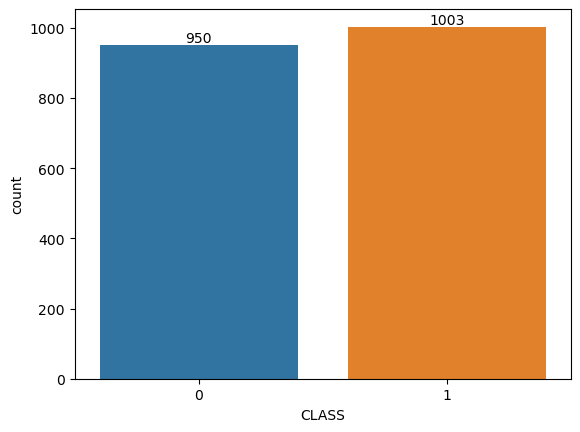

In [25]:
ax = sns.countplot(data, x = data['CLASS'])
ax.bar_label(ax.containers[0])

# 4. Processing Text

In [5]:
def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ''.join(sentence)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [6]:
data['clean_text'] = data['CONTENT'] \
                    .progress_apply(lower_text) \
                    .progress_apply(lemmatizer) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)])) \
                    .progress_apply(alphanumeric_text) 
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/1953 [00:00<?, ?it/s]

  0%|          | 0/1953 [00:00<?, ?it/s]

  0%|          | 0/1953 [00:00<?, ?it/s]

  0%|          | 0/1953 [00:00<?, ?it/s]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,clean_text
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this youtube channel kob..."
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,just for test i have to say murdev.com
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy _
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watchvvtarggvgtwq check this out .


In [8]:
data['clean_text']

0      huh, anyway check out this youtube channel kob...
1      hey guys check out my new channel and our firs...
2                 just for test i have to say murdev.com
3          me shaking my sexy ass on my channel enjoy _ 
4                     watchvvtarggvgtwq check this out .
                             ...                        
365    i love this song because we sing it at camp al...
366    i love this song for two reasons 1.it is about...
367                                                  wow
368                              shakira u are so wiredo
369                           shakira is the best dancer
Name: clean_text, Length: 1953, dtype: object

<Axes: xlabel='text_len'>

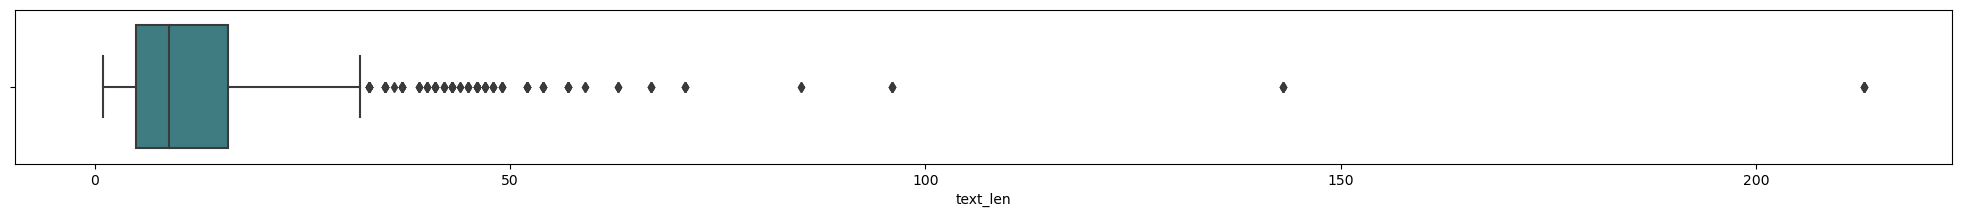

In [9]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [10]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(.94))

5.0
39.87999999999988


5.0
39.87999999999988


<Axes: xlabel='text_len'>

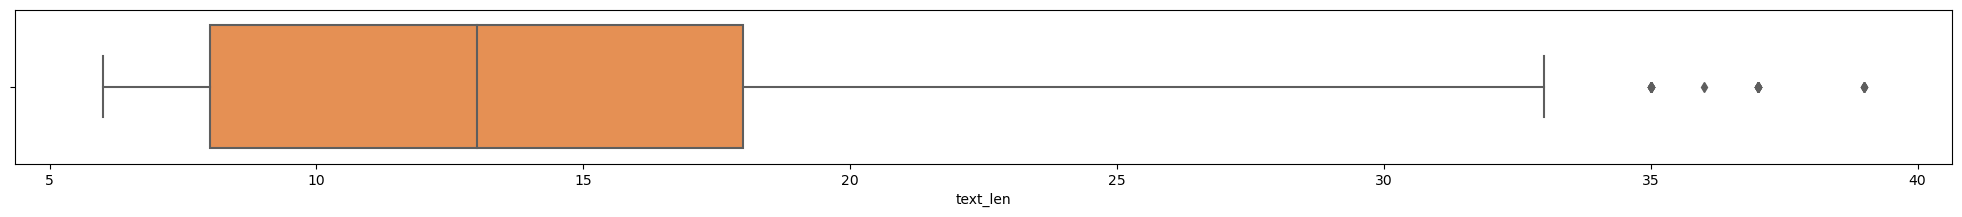

In [11]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(.94)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '616'), Text(0, 0, '640')]

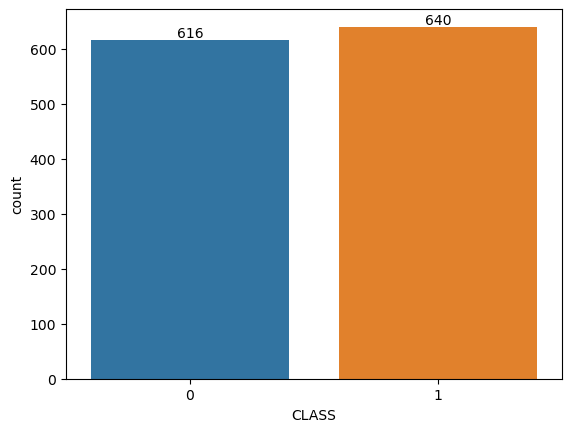

In [12]:
ax = sns.countplot(data, x = data['CLASS'])
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting Data

In [13]:
X = data['clean_text']
# Y = data['CLASS'] ### For Classification Algoritms
Y = to_categorical(data['CLASS']) ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(881,)
(249,)
(126,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [14]:
vocab_size = 3191
embedding_dim = 256
max_length = 40
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [15]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

3324


# 6. Classification Algoritms

In [101]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTress', extraTrees),
    # ('gradient', gradient),
    # ('knn', knn),
    # ('decisionTree', decisionTree),

], n_jobs=-1)

In [102]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fa...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [103]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')
print("Validating Score   :",round((model.score(validating_padded, validating_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 85.94 %
Validating Score   : 81.75 %
R Squared Error    : 0.44
Mean Squared Error : 0.14


In [104]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  0        0     0
1                  1        1     0
2                  0        0     0
3                  0        0     0
4                  0        1     1
35 / 249


In [105]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       113
           1       0.90      0.84      0.87       136

    accuracy                           0.86       249
   macro avg       0.86      0.86      0.86       249
weighted avg       0.86      0.86      0.86       249



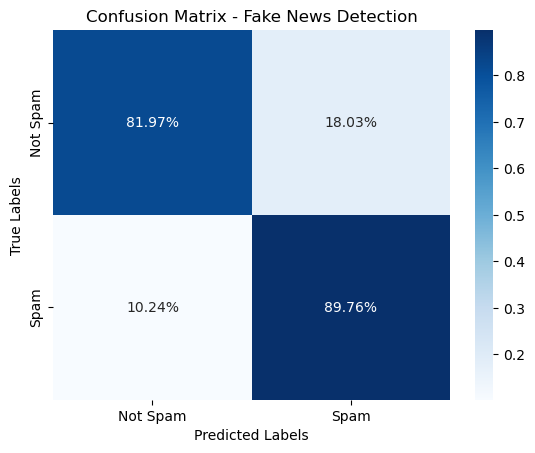

In [106]:
labels = ['Not Spam', 'Spam']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 7. Deep Learning Models

In [41]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(2, activation='softmax'))
    return model

# model = DNN_Model()
model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()



model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.000005)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 40, 256)           816896    
                                                                 
 conv1d_7 (Conv1D)           (None, 40, 64)            49216     
                                                                 
 batch_normalization_7 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 40, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 20, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 20, 64)          

In [42]:
num_epoch = 100
batch_size = 32

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/100
28/28 [==============================] - 4s 22ms/step - loss: 1.0228 - accuracy: 0.5017 - val_loss: 0.8612 - val_accuracy: 0.5079
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 0.9096 - accuracy: 0.5505 - val_loss: 0.8610 - val_accuracy: 0.5079
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 0.8552 - accuracy: 0.6005 - val_loss: 0.8608 - val_accuracy: 0.4921
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.8197 - accuracy: 0.6583 - val_loss: 0.8608 - val_accuracy: 0.5159
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 0.7939 - accuracy: 0.6833 - val_loss: 0.8609 - val_accuracy: 0.5238
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 0.7659 - accuracy: 0.7106 - val_loss: 0.8610 - val_accuracy: 0.4841
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.7417 - accuracy: 0.7242 - val_loss: 0.8610 - val_accuracy: 0.4921
Epoch 8/100


### 7.1. Evaluate The Model

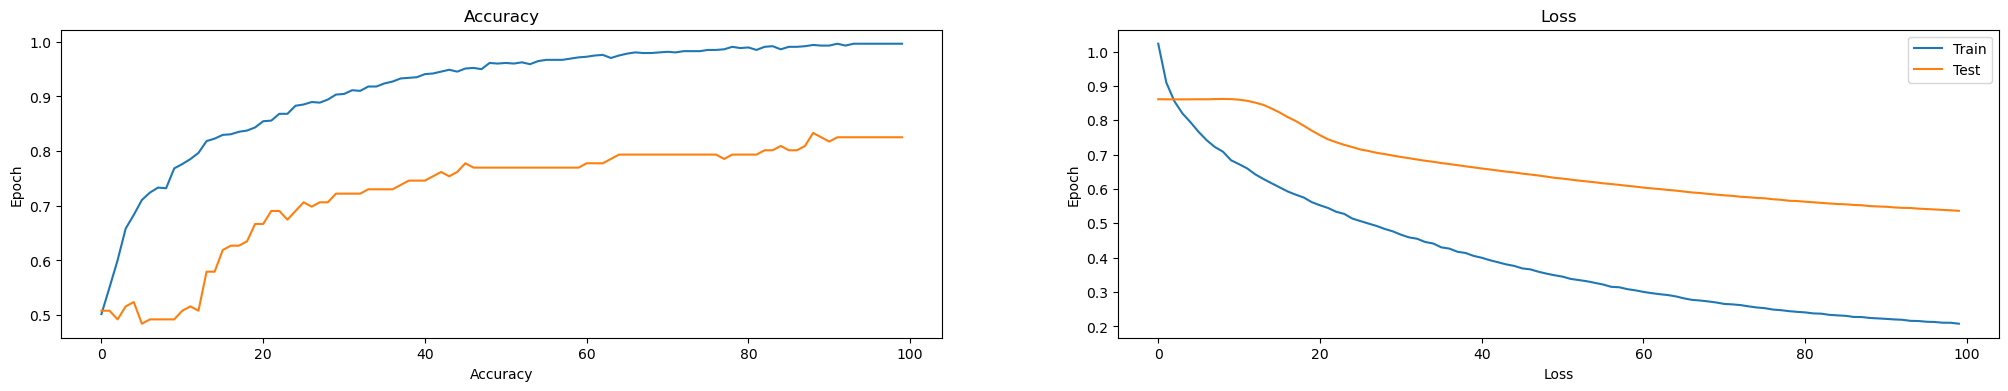

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [34]:
y_pred = model.predict(testing_padded, verbose = 0)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

R Squared Error    : 0.73
Mean Squared Error : 0.07


In [35]:
train_predictions = model.predict(testing_padded).argmax(axis=1)

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

8/8 [==============================] - 0s 2ms/step
   Train Predictions  Actuals  Diff
0                  0        0     0
1                  1        1     0
2                  0        0     0
3                  0        0     0
4                  0        1     1
23 / 249


In [36]:
y_pred = model.predict(testing_padded).argmax(axis=1)
print(classification_report(y_pred,testing_label.argmax(axis=1)))

8/8 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       117
           1       0.93      0.89      0.91       132

    accuracy                           0.91       249
   macro avg       0.91      0.91      0.91       249
weighted avg       0.91      0.91      0.91       249



8/8 [==============================] - 0s 2ms/step


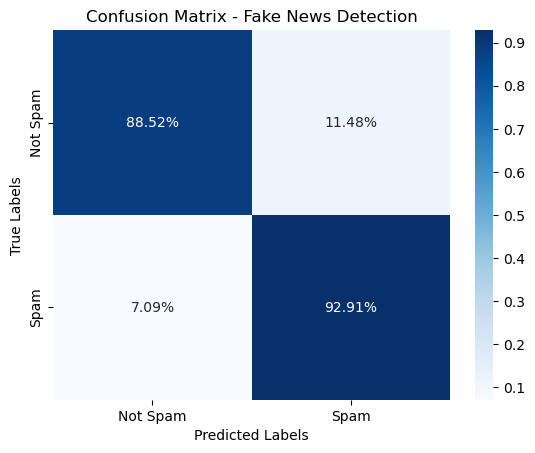

In [37]:
labels = ['Not Spam', 'Spam']


y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()